In [ ]:
%load_ext tensorboard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import os, cv2, json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, optimizers, applications, experimental, losses, utils
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score, precision_score, recall_score

#from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.applications import ResNet50, VGG16

from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [ ]:
ORI_DIR = os.getcwd()+"\ISIC_2008_challenge_3"
os.listdir(ORI_DIR)

['HAM10000_images',
 'HAM10000_metadata',
 'HAM10000_metadata.csv',
 'ISIC2018_Task3_Test_GroundTruth.csv',
 'ISIC2018_Task3_Test_Images',
 'ISIC2018_Task3_Validation_GroundTruth',
 'ISIC2018_Task3_Validation_GroundTruth.csv',
 'ISIC2018_Task3_Validation_Input']

In [ ]:
train_metadata = os.path.join(ORI_DIR, 'HAM10000_metadata.csv')
test_metadata = os.path.join(ORI_DIR, 'ISIC2018_Task3_Test_GroundTruth.csv')

In [ ]:
PRO_DIR = os.getcwd()+"\Processed_images"
os.listdir(PRO_DIR)

['test', 'train']

In [ ]:
pro_train_images_dir =os.path.join(PRO_DIR, 'train')
pro_test_images_dir =os.path.join(PRO_DIR, 'test')

In [ ]:
print('Processed Train images: %d' %len(os.listdir(pro_train_images_dir)))

Processed Train images: 10015


In [ ]:
print('Processed Test images: %d' %len(os.listdir(pro_test_images_dir)))

Processed Test images: 1511


In [ ]:
train_df = pd.read_csv(train_metadata)
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [ ]:
test_df = pd.read_csv(test_metadata)
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAMTEST_0000000,ISIC_0034524,nv,follow_up,40.0,female,back,vidir_molemax
1,HAMTEST_0000001,ISIC_0034525,nv,histo,70.0,male,abdomen,rosendahl
2,HAMTEST_0000002,ISIC_0034526,bkl,histo,70.0,male,back,rosendahl
3,HAMTEST_0000003,ISIC_0034527,nv,histo,35.0,male,trunk,vienna_dias
4,HAMTEST_0000004,ISIC_0034528,nv,follow_up,75.0,female,trunk,vidir_molemax


In [ ]:
name_dict = {
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevus',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesion'
}

In [ ]:
label_dict = {
    'mel': '0',
    'nv': '1',
    'bcc': '2',
    'akiec': '3',
    'bkl': '4',
    'df': '5',
    'vasc': '6'
}

In [ ]:
train_df['name'] = train_df['dx'].map(name_dict.get)
train_df['label'] = train_df['dx'].map(label_dict.get)

test_df['name'] = test_df['dx'].map(name_dict.get)
test_df['label'] = test_df['dx'].map(label_dict.get)

In [ ]:
train_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,name,label
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,Actinic keratosis,3
10014,HAM_0003521,ISIC_0032258,mel,histo,70.0,female,back,vidir_modern,Melanoma,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
 8   name          10015 non-null  object 
 9   label         10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.6+ KB


In [ ]:
train_df['label'] = train_df['dx'].map(label_dict)
test_df['label'] = test_df['dx'].map(label_dict)

In [ ]:
# Convert labels to string to use with ImageDataGenerator
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:
train_df['image_id'] = train_df['image_id'] + '.jpg'
test_df['image_id'] = test_df['image_id'] + '.jpg'

In [ ]:
train_df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,name,label
10010,HAM_0002867,ISIC_0033084.jpg,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10011,HAM_0002867,ISIC_0033550.jpg,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10012,HAM_0002867,ISIC_0033536.jpg,akiec,histo,40.0,male,abdomen,vidir_modern,Actinic keratosis,3
10013,HAM_0000239,ISIC_0032854.jpg,akiec,histo,80.0,male,face,vidir_modern,Actinic keratosis,3
10014,HAM_0003521,ISIC_0032258.jpg,mel,histo,70.0,female,back,vidir_modern,Melanoma,0


In [ ]:
label_dict = {value: key for key, value in label_dict.items()}
label_dict

{'0': 'mel',
 '1': 'nv',
 '2': 'bcc',
 '3': 'akiec',
 '4': 'bkl',
 '5': 'df',
 '6': 'vasc'}

In [ ]:
# Split into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=pro_train_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=pro_train_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Test data generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=pro_test_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1511 validated image filenames belonging to 7 classes.


In [ ]:

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_dict), activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
251/251 [==============================] - 551s 2s/step - loss: 1.0658 - accuracy: 0.6661 - val_loss: 0.9005 - val_accuracy: 0.6755
Epoch 2/10
251/251 [==============================] - 521s 2s/step - loss: 0.8835 - accuracy: 0.6794 - val_loss: 0.8717 - val_accuracy: 0.6840
Epoch 3/10
251/251 [==============================] - 497s 2s/step - loss: 0.8145 - accuracy: 0.7009 - val_loss: 0.8086 - val_accuracy: 0.6955
Epoch 4/10
251/251 [==============================] - 500s 2s/step - loss: 0.7637 - accuracy: 0.7183 - val_loss: 0.8003 - val_accuracy: 0.7094
Epoch 5/10
251/251 [==============================] - 491s 2s/step - loss: 0.7143 - accuracy: 0.7355 - val_loss: 0.7928 - val_accuracy: 0.7029
Epoch 6/10
251/251 [==============================] - 509s 2s/step - loss: 0.6772 - accuracy: 0.7490 - val_loss: 0.8126 - val_accuracy: 0.7134
Epoch 7/10
251/251 [==============================] - 501s 2s/step - loss: 0.6499 - accuracy: 0.7596 - val_loss: 0.7370 - val_accuracy: 0.7224

In [ ]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc}')

63/63 [==============================] - 34s 542ms/step - loss: 0.8646 - accuracy: 0.7164
Validation accuracy: 0.716425359249115


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
epochs_range = range(len(acc))

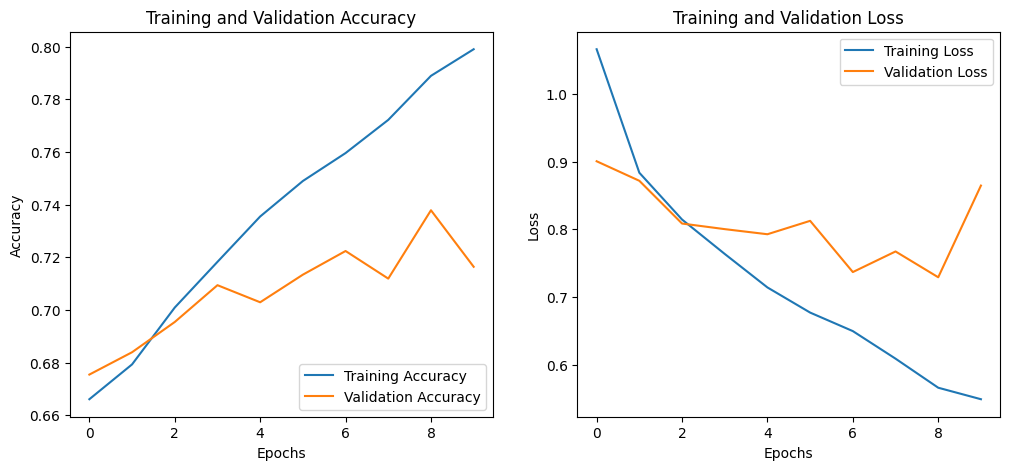

In [ ]:
# Plot of training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:
"""
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.title('Model accuracy')
plt.legend()
plt.show()

"""

'\nplt.plot(history.history["accuracy"] , \'ro-\' , label = "Training Accuracy")\nplt.plot(history.history["val_accuracy"] , \'go-\' , label = "Testing Accuracy")\nplt.title(\'Model accuracy\')\nplt.legend()\nplt.show()\n\n'

In [ ]:
"""
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.title('Model loss')
plt.show()
"""

'\nplt.plot(history.history["loss"] , \'ro-\' , label = "Training Loss")\nplt.plot(history.history["val_loss"] , \'go-\' , label = "Testing Loss")\nplt.legend()\nplt.title(\'Model loss\')\nplt.show()\n'

In [ ]:
# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 [==============================] - 44s 909ms/step


In [ ]:
len(predicted_classes)

1511

In [ ]:
# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes


array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy
#print(f'Accuracy: {accuracy:.2f}')

0.6505625413633356

In [ ]:
class_indices = list(label_dict.keys())

# Convert label_dict to a list of class names in the correct order
target_names = [label_dict[idx] for idx in class_indices]

In [ ]:
target_names

['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']

In [ ]:
class_indices

['0', '1', '2', '3', '4', '5', '6']

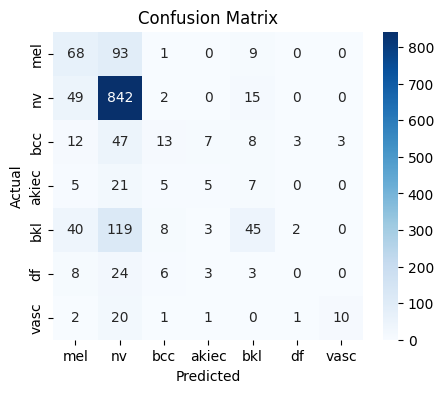

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
"""
class_indices = list(label_dict.keys())

# Convert label_dict to a list of class names in the correct order
target_names = [label_dict[idx] for idx in class_indices]
"""
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)


              precision    recall  f1-score   support

         mel       0.37      0.40      0.38       171
          nv       0.72      0.93      0.81       908
         bcc       0.36      0.14      0.20        93
       akiec       0.26      0.12      0.16        43
         bkl       0.52      0.21      0.30       217
          df       0.00      0.00      0.00        44
        vasc       0.77      0.29      0.42        35

   micro avg       0.65      0.65      0.65      1511
   macro avg       0.43      0.30      0.32      1511
weighted avg       0.60      0.65      0.60      1511



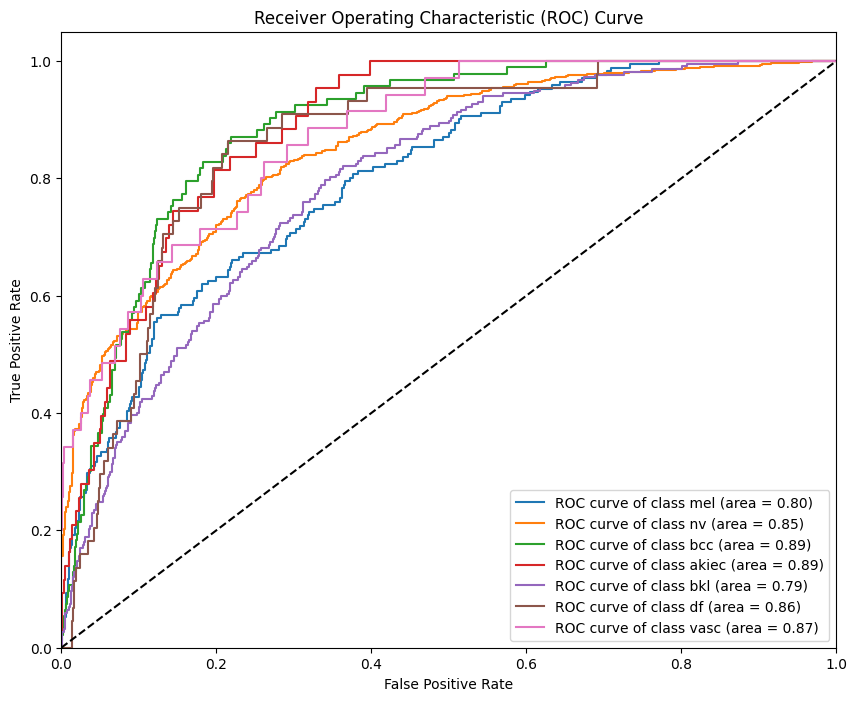

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### metrics individual classes

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy = np.round(accuracy, 2)


# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
sensitivity = np.round(sensitivity, 2)

#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)
map_score = np.round(map_score, 2)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)
f1 = np.round(f1, 2)

# Positive Predictive Value (PPV) (Precision)
ppv = precision_score(true_classes, predicted_classes, average=None)
ppv = np.round(ppv, 2)


# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

npv = np.round(npv, 2)
specificity = np.round(specificity, 2)

'\nsensitivity = [f"{x:.2f}" for x in sensitivity]\nspecificity = [f"{x:.2f}" for x in specificity]\nf1 = [f"{x:.2f}" for x in f1]\nmap_score = [f"{x:.2f}" for x in map_score]\nppv = [f"{x:.2f}" for x in ppv]\nnpv = [f"{x:.2f}" for x in npv]\n'

In [ ]:
# Create a dictionary with all the metrics
metrics_dict = {
    'Class': target_names,
    'Accuracy': accuracy,
    #'Accuracy per class': per_class_accuracy,
    'Sensitivity (Recall)': sensitivity,
    'Specificity': specificity,
    'F1 Score': f1,
    'MAP Score': map_score,
    'PPV (Precision)': ppv,
    'NPV': npv
}

# Create the dataframe
metrics_df = pd.DataFrame(metrics_dict)

metrics_df


,Class,Accuracy,Sensitivity (Recall),Specificity,F1 Score,MAP Score,PPV (Precision),NPV
0,mel,0.65,0.40,0.91,0.38,0.39,0.37,0.92
1,nv,0.65,0.93,0.46,0.81,0.90,0.72,0.81
2,bcc,0.65,0.14,0.98,0.20,0.31,0.36,0.95
3,akiec,0.65,0.12,0.99,0.16,0.22,0.26,0.97
4,bkl,0.65,0.21,0.97,0.30,0.39,0.52,0.88
5,df,0.65,0.00,1.00,0.00,0.12,0.00,0.97
6,vasc,0.65,0.29,1.00,0.42,0.39,0.77,0.98


# Transfer Learning no fine tunning

In [ ]:
# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 10

In [ ]:
# Load the pre-trained ResNet50 model, exclude top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze all layers in the base model
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use global average pooling instead of flattening
x = Dense(1024, activation='relu')(x)  # Fully connected layer with 1024 units
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
output = Dense(NUM_CLASSES, activation='softmax')(x)  # Final output layer with softmax activation for classification


In [ ]:
# Build the final model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the model architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Split into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
#Data augmentation for training and set up for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=pro_train_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=pro_train_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Test data generator

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=pro_test_images_dir,
    x_col='image_id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1511 validated image filenames belonging to 7 classes.


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/10
250/250 [==============================] - 2812s 11s/step - loss: 1.0421 - accuracy: 0.6731 - val_loss: 0.9297 - val_accuracy: 0.6825
Epoch 2/10
250/250 [==============================] - 2788s 11s/step - loss: 0.9508 - accuracy: 0.6847 - val_loss: 0.9073 - val_accuracy: 0.6840
Epoch 3/10
250/250 [==============================] - 2798s 11s/step - loss: 0.9221 - accuracy: 0.6872 - val_loss: 0.8978 - val_accuracy: 0.6784
Epoch 4/10
250/250 [==============================] - 2998s 12s/step - loss: 0.9055 - accuracy: 0.6832 - val_loss: 0.8638 - val_accuracy: 0.6941
Epoch 5/10
250/250 [==============================] - 2867s 11s/step - loss: 0.8891 - accuracy: 0.6932 - val_loss: 0.8587 - val_accuracy: 0.6870
Epoch 6/10
250/250 [==============================] - 2762s 11s/step - loss: 0.8789 - accuracy: 0.6883 - val_loss: 0.8971 - val_accuracy: 0.6633
Epoch 7/10
250/250 [==============================] - 2849s 11s/step - loss: 0.8740 - accuracy: 0.6905 - val_loss: 0.8432 - val_ac

In [ ]:

# Evaluate the model on the validation/test set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


63/63 [==============================] - 557s 9s/step - loss: 0.8243 - accuracy: 0.6930
Validation Loss: 0.824285089969635, Validation Accuracy: 0.6929605603218079


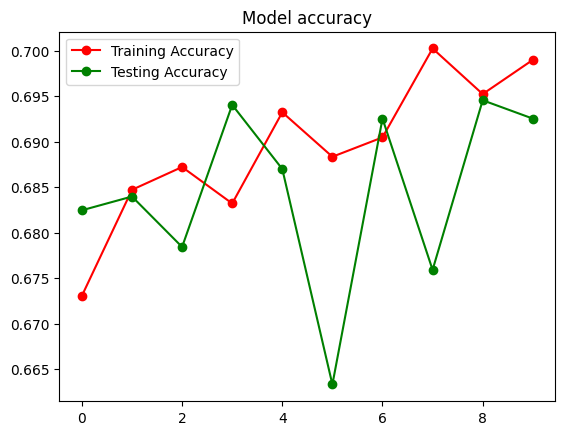

In [ ]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.title('Model accuracy')
plt.legend()
plt.show()


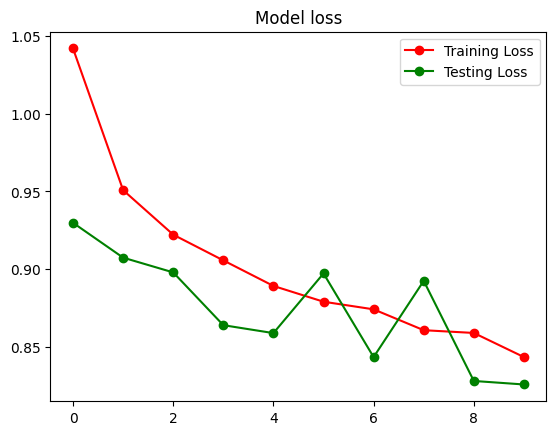

In [ ]:

plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.title('Model loss')
plt.show()


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
epochs_range = range(len(acc))

In [ ]:
# Plot of training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [ ]:

# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 [==============================] - 418s 9s/step


In [ ]:

len(predicted_classes)

1511

In [ ]:

# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes

array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy
#print(f'Accuracy: {accuracy:.2f}')



0.6604897418927862

In [ ]:

class_indices = list(label_dict.keys())

# Convert label_dict to a list of class names in the correct order
target_names = [label_dict[idx] for idx in class_indices]


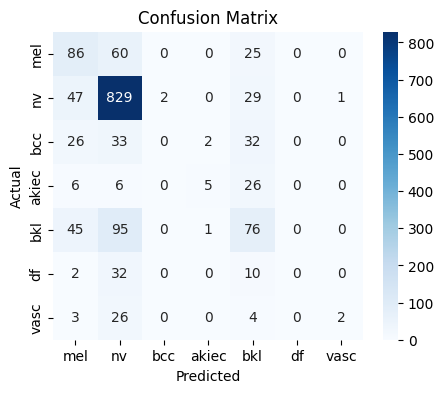

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)

              precision    recall  f1-score   support

         mel       0.40      0.50      0.45       171
          nv       0.77      0.91      0.83       908
         bcc       0.00      0.00      0.00        93
       akiec       0.62      0.12      0.20        43
         bkl       0.38      0.35      0.36       217
          df       0.00      0.00      0.00        44
        vasc       0.67      0.06      0.11        35

   micro avg       0.66      0.66      0.66      1511
   macro avg       0.40      0.28      0.28      1511
weighted avg       0.59      0.66      0.61      1511



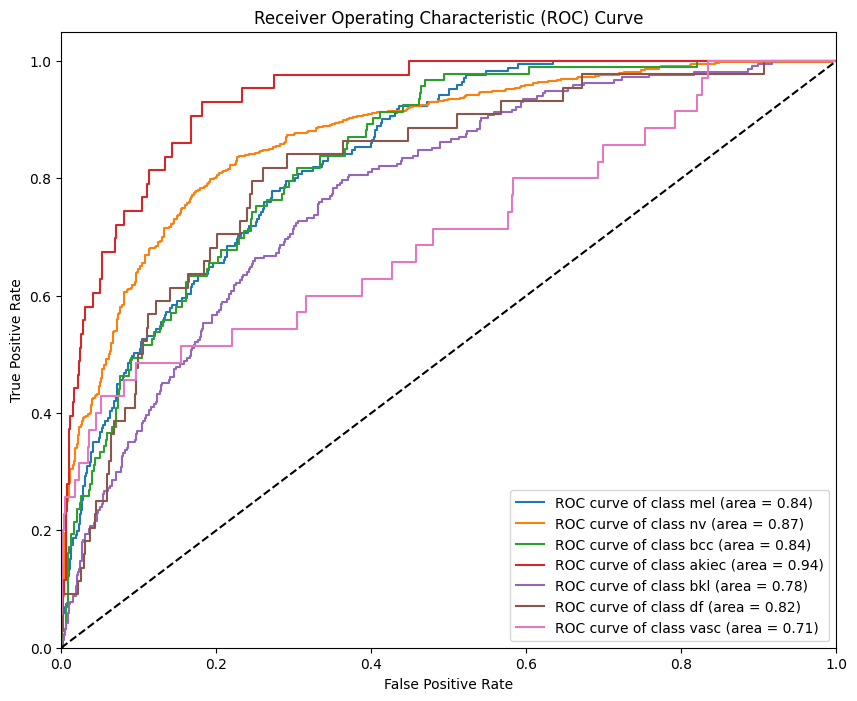

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)

# Positive Predictive Value (PPV)
ppv = precision_score(true_classes, predicted_classes, average=None)

"""
# Negative Predictive Value (NPV)
tn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
fn = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
tp = np.diag(conf_matrix)
fp = conf_matrix.sum() - (tp + fn + tn)
npv = tn / (tn + fn)
npv = np.mean(npv)  # Mean NPV for all classes
"""

# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

sensitivity = [f"{x:.2f}" for x in sensitivity]
specificity = [f"{x:.2f}" for x in specificity]
f1 = [f"{x:.2f}" for x in f1]
map_score = [f"{x:.2f}" for x in map_score]
ppv = [f"{x:.2f}" for x in ppv]
npv = [f"{x:.2f}" for x in npv]

In [ ]:
# Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall) : {', '.join(sensitivity)}")
print(f"Specificity : {', '.join(specificity)}")
print(f"F1 Score : {', '.join(f1)}")
print(f"Mean Average Precision (MAP) : {', '.join(map_score)}")
print(f"Positive Predictive Value (PPV) : {', '.join(ppv)}")
print(f"Negative Predictive Value (NPV) : {', '.join(npv)}")


Accuracy: 0.66
Sensitivity (Recall) : 0.50, 0.91, 0.00, 0.12, 0.35, 0.00, 0.06
Specificity : 0.90, 0.58, 1.00, 1.00, 0.90, 1.00, 1.00
F1 Score : 0.45, 0.83, 0.00, 0.20, 0.36, 0.00, 0.11
Mean Average Precision (MAP) : 0.42, 0.91, 0.26, 0.37, 0.36, 0.16, 0.25
Positive Predictive Value (PPV) : 0.40, 0.77, 0.00, 0.62, 0.38, 0.00, 0.67
Negative Predictive Value (NPV) : 0.93, 0.82, 0.94, 0.97, 0.89, 0.97, 0.98


# Transfer learning with fine tunning

In [ ]:
# Fine-tuning: unfreeze a few layers of the base model
for layer in base_model.layers[-7:]:  # Unfreeze the last 50 layers
    layer.trainable = True


In [ ]:
# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the model architecture
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs


In [ ]:
history_fine_tune = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)



Epoch 10/20
250/250 [==============================] - 5576s 22s/step - loss: 0.7868 - accuracy: 0.7178 - val_loss: 0.7692 - val_accuracy: 0.7233
Epoch 11/20
250/250 [==============================] - 4657s 19s/step - loss: 0.7227 - accuracy: 0.7416 - val_loss: 0.7368 - val_accuracy: 0.7339
Epoch 12/20
250/250 [==============================] - 4623s 18s/step - loss: 0.6749 - accuracy: 0.7593 - val_loss: 0.7057 - val_accuracy: 0.7475
Epoch 13/20
250/250 [==============================] - 4624s 19s/step - loss: 0.6421 - accuracy: 0.7650 - val_loss: 0.6757 - val_accuracy: 0.7566
Epoch 14/20
250/250 [==============================] - 4655s 19s/step - loss: 0.6248 - accuracy: 0.7746 - val_loss: 0.6331 - val_accuracy: 0.7707
Epoch 15/20
250/250 [==============================] - 4660s 19s/step - loss: 0.5992 - accuracy: 0.7821 - val_loss: 0.6510 - val_accuracy: 0.7646
Epoch 16/20
250/250 [==============================] - 4789s 19s/step - loss: 0.5711 - accuracy: 0.7895 - val_loss: 0.6209 -

In [ ]:
# Evaluate the model on the validation/test set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

63/63 [==============================] - 587s 9s/step - loss: 0.5952 - accuracy: 0.7838
Validation Loss: 0.5951514840126038, Validation Accuracy: 0.7838242650032043


In [ ]:
# Combine the training accuracy and loss from the initial phase and fine-tuning phase
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']


In [ ]:
# Create a combined epoch range
epochs_range = range(len(acc))

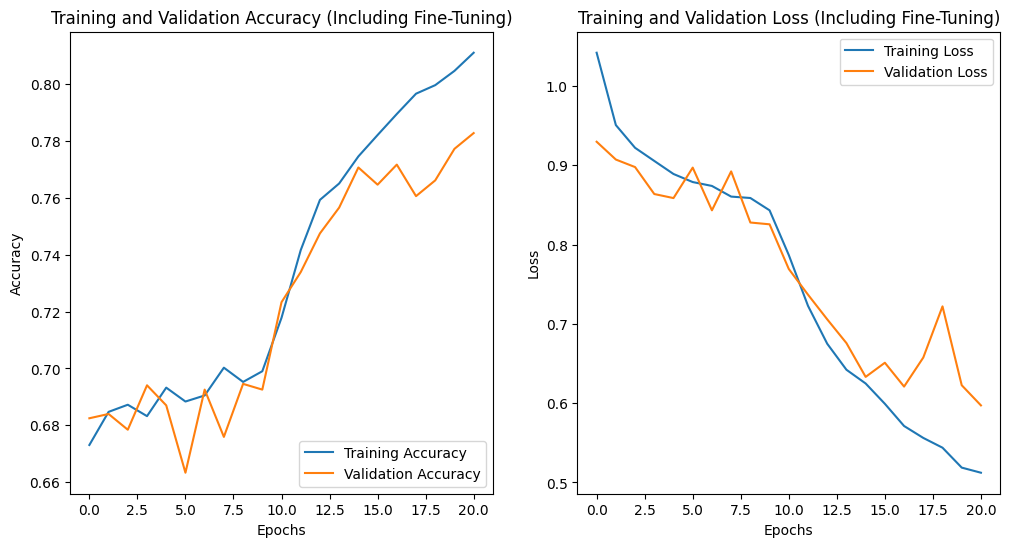

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Including Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (Including Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:

# Make predictions on the test set
test_images, test_labels = next(test_generator)
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
#true_classes = np.argmax(test_labels, axis=1)


48/48 [==============================] - 452s 9s/step


In [ ]:

len(predicted_classes)

1511

In [ ]:

# Extract true classes from the test generator
true_classes = test_generator.classes
true_classes = np.array(true_classes)
true_classes

array([1, 1, 4, ..., 3, 4, 2])

In [ ]:
len(true_classes)

1511

In [ ]:
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
accuracy
#print(f'Accuracy: {accuracy:.2f}')



0.7352746525479815

In [ ]:

class_indices = list(label_dict.keys())

# Convert label_dict to a list of class names in the correct order
target_names = [label_dict[idx] for idx in class_indices]


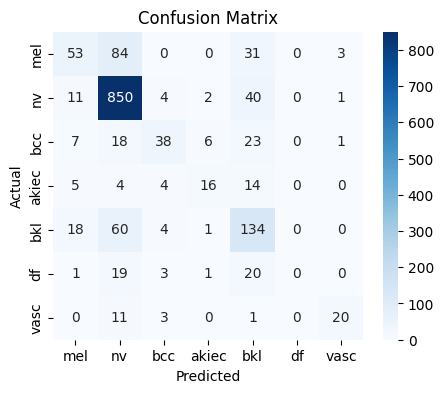

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=target_names, labels=class_indices)
print(report)

              precision    recall  f1-score   support

         mel       0.56      0.31      0.40       171
          nv       0.81      0.94      0.87       908
         bcc       0.68      0.41      0.51        93
       akiec       0.62      0.37      0.46        43
         bkl       0.51      0.62      0.56       217
          df       0.00      0.00      0.00        44
        vasc       0.80      0.57      0.67        35

   micro avg       0.74      0.74      0.74      1511
   macro avg       0.57      0.46      0.50      1511
weighted avg       0.70      0.74      0.71      1511



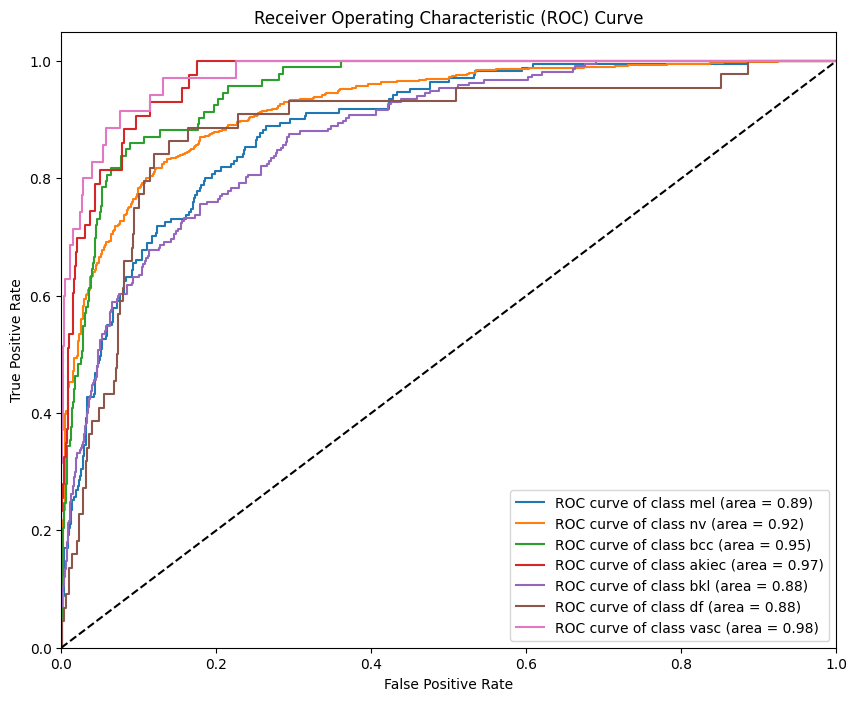

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

"""
# Binarize the output
true_classes_binarized = tf.keras.utils.to_categorical(true_classes, num_classes=len(label_dict))
"""

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(true_classes_binarized[:, i], predictions[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {target_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Sensitivity (Recall) #and Specificity
sensitivity = recall_score(true_classes, predicted_classes, average=None)
#specificity = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix) - sensitivity

# Mean Average Precision (MAP)
map_score = average_precision_score(true_classes_binarized, predictions, average=None)

# F1 Score
f1 = f1_score(true_classes, predicted_classes, average=None)

# Positive Predictive Value (PPV)
ppv = precision_score(true_classes, predicted_classes, average=None)

"""
# Negative Predictive Value (NPV)
tn = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
fn = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
tp = np.diag(conf_matrix)
fp = conf_matrix.sum() - (tp + fn + tn)
npv = tn / (tn + fn)
npv = np.mean(npv)  # Mean NPV for all classes
"""

# Calculate NPV and Specificity
npv = []
specificity = []

for i in range(len(label_dict)):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - (tp + fp + fn)

    # NPV: True Negatives / (True Negatives + False Negatives)
    npv_ = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Specificity: True Negatives / (True Negatives + False Positives)
    specificity_ = tn / (tn + fp) if (tn + fp) > 0 else 0

    npv.append(npv_)
    specificity.append(specificity_)

sensitivity = [f"{x:.2f}" for x in sensitivity]
specificity = [f"{x:.2f}" for x in specificity]
f1 = [f"{x:.2f}" for x in f1]
map_score = [f"{x:.2f}" for x in map_score]
ppv = [f"{x:.2f}" for x in ppv]
npv = [f"{x:.2f}" for x in npv]

In [ ]:
# Results
print(f"Accuracy: {accuracy:.2f}")
print(f"Sensitivity (Recall) : {', '.join(sensitivity)}")
print(f"Specificity : {', '.join(specificity)}")
print(f"F1 Score : {', '.join(f1)}")
print(f"Mean Average Precision (MAP) : {', '.join(map_score)}")
print(f"Positive Predictive Value (PPV) : {', '.join(ppv)}")
print(f"Negative Predictive Value (NPV) : {', '.join(npv)}")


Accuracy: 0.74
Sensitivity (Recall) : 0.31, 0.94, 0.41, 0.37, 0.62, 0.00, 0.57
Specificity : 0.97, 0.67, 0.99, 0.99, 0.90, 1.00, 1.00
F1 Score : 0.40, 0.87, 0.51, 0.46, 0.56, 0.00, 0.67
Mean Average Precision (MAP) : 0.54, 0.95, 0.58, 0.60, 0.60, 0.20, 0.70
Positive Predictive Value (PPV) : 0.56, 0.81, 0.68, 0.62, 0.51, 0.00, 0.80
Negative Predictive Value (NPV) : 0.92, 0.88, 0.96, 0.98, 0.93, 0.97, 0.99
